<a href="https://cognitiveclass.ai"><img src = "https://www.incimages.com/uploaded_files/image/970x450/getty_178563764_77515.jpg" width = 400> </a>

<h1 align=center><font size = 5>CAPSTONE PROJECT: Where to Find a Job in Switzerland?</font></h1>
<h2 align=center><font size = 5>Author: HongX</font></h2><h2 align=center><font size = 4>Student at ETH Zürich (2019)</font></h2>

# [1] Introduction

In this notebook, I presented how to apply the knowledge learned from coursera data science courses to the guide the answer to the question: Where to find a job in Switzerland? 

 

List of used tools/Sources:  
1. **Python 3**  
2. **Foursqure**  
3. **Swiss Federal Statistical Office**  
4. **Skills Network Labs Platform**  

*Partially Adapted notebook from course: DP0701EN-3-3-2-Neighborhoods-New-York-py-v1.0.ipynb

# [2] Background

**Preface:**

Has been studying in Switzerland for 3 years, I'm very excited to get a chance to apply my learned knowledge to the industrial applications, especially on the renewable energy field. While the first question I got encountered is how to find a good-matched job? This is not a new question but might be a quite headache one for many domestic/foreign students when their graduation is approaching. Pursing the IBM data science professional certificate is my efforts towards find a good job. Thus I am highly motivated to gain some preparation knowledge on the job market in Switzerland by exploiting the tools I have learned and practiced during the Coursera courses.

This notebook is structured as following:  

1. **Introduction**  

2. **Background and Motivation**

3. **Data Sources**

4. **Swiss Demographics**

5. **Where is the Chance for Foreigners?** 

6. **Which City to Live?**  

7. **How is Life?**  

8. **Good Luck!**  

# [3] Data Sources

1. The Swiss demographics data is from Swiss Federal Statistical Office, including population, business, nature environments, politics statistics;

2. The neighborhood data for city is requested from Foursqure.

### 3.1 Import Preparation

In [1]:
from IPython.display import clear_output
clear_output(wait=True)

import os,sys, glob, statistics
import shapefile as shp  # Requires the pyshp package
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import urllib.request
import pandas as pd
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from skimage import transform,data,io
import matplotlib.colors as colors
from numpy import isnan

!pip install pyshp
!pip install shapely
!pip install descartes
!pip install scikit-image
!pip install xlrd

%matplotlib inline
print ("All packages imported!")

All packages imported!


In [2]:
#Define Global Parameters for path to file
global loc_path_to_shp; loc_path_to_shp = '/resources/labs/Zurich/input/geodata/gde-1-1-15.shp'
global loc_path_to_tif; loc_path_to_tif = '/resources/labs/Zurich/input/geodata/02-relief-georef-clipped-resampled.tif'
global loc_path_to_csv; loc_path_to_csv = '/resources/labs/Zurich/input/avg_age_15.csv'
global loc_path_to_swiss; loc_path_to_swiss = '/resources/labs/Zurich/input/Statistics_of_Switzerland_County_Level.xlsx'

In [3]:
"""
 Read shape file for later processing
"""
#Read shape file
#encoding is western europe language cp850
sf = shp.Reader(loc_path_to_shp,encoding='cp850')

#Explore the shapefile and data structure
fields = sf.fields
print (fields)

shapeRecs = sf.shapeRecords()
for i in range(10):
    print (shapeRecs[i].record)

#Explore the shape file
xx = []
yy = []
print ('Num of Shapes: ', len(list(sf.iterShapes())))
for shape in list(sf.iterShapes()):
    for i in range(len(shape.points)):
        xx.append(shape.points[i][0])
        yy.append(shape.points[i][1])

print ('Num of Points: ', len(xx),len(yy))        

minMaxDim = [max(xx), min(xx), max(yy), min(yy)]
print ('Max and Min: ',minMaxDim)

width=int((max(xx)-min(xx))/70)
height=int((max(yy)-min(yy))/70)
print ('Width & height: ', width, height)
print ("-------")

[('DeletionFlag', 'C', 1, 0), ['Secondary_', 'C', 32, 0], ['BFS_ID', 'N', 10, 0]]
Record #0: ['Aeugst am Albis', 1]
Record #1: ['Affoltern am Albis', 2]
Record #2: ['Bonstetten', 3]
Record #3: ['Hausen am Albis', 4]
Record #4: ['Hedingen', 5]
Record #5: ['Kappel am Albis', 6]
Record #6: ['Knonau', 7]
Record #7: ['Maschwanden', 8]
Record #8: ['Mettmenstetten', 9]
Record #9: ['Obfelden', 10]
Num of Shapes:  2324
Num of Points:  29040 29040
Max and Min:  [833175.0922758272, 485203.09316936514, 295864.00129457185, 75283.00188966928]
Width & height:  4971 3151
-------


In [4]:
"""
 Read Statistics to DataFrame
"""
#Read xlsx to DataFrame
df_swiss = pd.read_excel(loc_path_to_swiss, skiprows=5)

#Clean the Gemindecode = NaN
df_swiss['Gemeindecode'] = df_swiss['Gemeindecode'].fillna('Empty')
df_swiss['Gemeindename'] = df_swiss['Gemeindename'].fillna('Empty')
df_swiss.drop(df_swiss.index[df_swiss.index[df_swiss['Gemeindecode'] == "Empty"]], inplace=True)
#df_swiss.drop(df_swiss.tail(12).index,inplace=True) 
print ('Dataframe shape: ',df_swiss.shape)
df_swiss.tail(10)
df_swiss.head(10)

Dataframe shape:  (2212, 43)


,Gemeindecode,Gemeindename,Population,Changes in %,Population density per km²,Foreigner %,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Raw marriage rate,...,FDP 3),CVP,SP,SVP,EVP/CSP,GLP,BDP,PdA/Sol.,GPS,Small right-wing parties
3,1,Aeugst am Albis,1941.0,6.41447,245.385588,12.725399,19.629057,62.493560,17.877383,5.104645,...,18.6917,2.07643,18.6459,30.9292,3.46706,8.43525,2.61744,0.167638,7.07509,4.88818
4,2,Affoltern am Albis,12146.0,9.51222,1146.931067,28.593776,20.805203,61.444097,17.750700,5.905348,...,14.2266,4.58539,19.0803,33.7858,5.46483,7.35786,4.1643,0.190049,6.21105,1.7682
5,3,Bonstetten,5512.0,6.84241,741.857335,15.475327,23.784470,60.413643,15.801887,4.019366,...,16.4726,3.37854,20.4033,29.1002,3.143,11.8624,3.80311,0.112518,6.66107,1.91581
6,4,Hausen am Albis,3664.0,9.04762,269.411765,15.147380,22.652838,60.125546,17.221616,4.422944,...,12.7937,2.88192,19.3933,34.9374,2.56987,8.74827,4.65609,0.193911,8.02166,1.82544
7,5,Hedingen,3694.0,8.32845,565.696784,15.240931,22.387656,61.586356,16.025988,4.335456,...,15.8058,3.91817,22.478,30.1146,3.5893,9.62594,3.76886,0.227988,6.46639,1.84005
8,6,Kappel am Albis,1125.0,22.549,142.045455,18.400000,25.955556,60.711111,13.333333,5.369128,...,10.9525,2.74447,10.2854,48.6151,6.60361,5.62405,5.13427,0.312447,4.38271,2.7698
9,7,Knonau,2305.0,28.0556,356.259660,17.613883,23.817787,61.344902,14.837310,3.129890,...,11.4566,3.12605,18.4366,32.8761,6.16796,10.4216,5.94497,0.00841468,5.80192,3.43739
10,8,Maschwanden,641.0,4.05844,136.673774,11.232449,23.400936,59.126365,17.472699,1.578532,...,4.89014,3.5024,22.7325,43.3834,3.73369,4.8571,3.45283,0.644309,5.17099,2.11465
11,9,Mettmenstetten,4886.0,15.1544,374.980814,14.388047,22.554237,59.885387,17.560377,5.129784,...,13.1847,3.64916,18.8003,35.671,3.46806,9.6205,4.3527,0.133017,5.05946,3.56902
12,10,Obfelden,5356.0,14.2979,710.344828,20.481703,23.076923,60.212845,16.710232,4.577095,...,14.413,6.48818,16.9221,36.174,4.79263,7.38864,4.35812,0.0869035,3.70542,2.98245


### Create Color Gradient for Visulization

Color Map:  viridis 153 colors


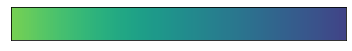

In [15]:
#Color Mapping Values for Plot
cmaps = ['viridis', 'plasma', 'cool', 'magma',  'gnuplot', 'gnuplot2']
cmap_selected = cmaps[0]

#For printing any progress bar
def progress(count, total, suffix=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()  # As suggested by Rom Ruben

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    #print (cmap.name, len(grayscale),'colors' ) 
    
    #fig, ax = plt.subplots(2, figsize=(6, 2),
    #                       subplot_kw=dict(xticks=[], yticks=[]))
    #ax[0].imshow([colors], extent=[0, 10, 0, 1])
    #ax[1].imshow([grayscale], extent=[0, 10, 0, 1])
    
    return colors

def truncate_colormap(cmapIn=cmap_selected, minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''    
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    #arr = np.linspace(0, 50, 100).reshape((10, 10))
    #fig, ax = plt.subplots(ncols=2)
    #ax[0].imshow(arr, interpolation='nearest', cmap=cmapIn)
    #ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
    #plt.show()

    return new_cmap

#Trim the spectrum
cmap_trim= truncate_colormap(cmapIn=cmap_selected,minval=.2, maxval=.8) 

magma_cmaps = view_colormap(cmap_selected)
magma_cmaps = magma_cmaps[51:204]
print ('Color Map: ', cmap_selected, len(magma_cmaps), 'colors')

#Plot Bar
fig, ax = plt.subplots(1, figsize=(6, 2),subplot_kw=dict(xticks=[], yticks=[]))
ax.imshow([np.flipud(magma_cmaps)], extent=[0, 10, 0, 1])
ax.set_xticklabels(['<37', '39','41', '43', '45', '>47'])
plt.show()

### Create Function for Thematic Plot

In [6]:
#Define the general thematic plot function
def thematic_plot(data_list, gemeindename, gemeindecode, variable_max, variable_min, variable_name, cmapv=cmap_selected,titlev='Region of Switzerland',cb_titlev='Color Bar', cb_ticks=['20','40','60','80','100'], mmDim = minMaxDim, width=width, height=height):
   
    import numpy as np
    
    #Read shape file angain
    sf = shp.Reader(loc_path_to_shp,encoding='cp850')

    # Plot chorologie maps settings
    fig = plt.figure(figsize=(15,11))
    ax = plt.axes() # add the axes
    fig.patch.set_alpha(0.0)
    
    #minMaxDim = [max(xx), min(xx), max(yy), min(yy)]
    plt.xlim(mmDim[1],mmDim[0])
    plt.ylim(mmDim[3],mmDim[2])
    print ('Plot MinMax, Width, Height: ', mmDim, width, height)
    
    #Read the background mountain image
    img = plt.imread(loc_path_to_tif)
    print ('BG Img Shape: ', img.shape)

    img_rzd=transform.resize(img, (height, width))
    print ('BG Img Resized Shape: ', img_rzd.shape)

    #Show BG mountain image
    ax.imshow(img_rzd, extent=[mmDim[1], mmDim[0], mmDim[3], mmDim[2]])
    
    # index of shape, index of data_list
    global icolor; icolor = 0   #IMPORTANT PARAMETER
    
    #Read each shape in shapefile, and plot the polygon
    for shape in list(sf.iterShapes()):
        
        #print ('iColor:', icolor, end = '')
        
        #Get ID from shape 
        gemeindeID = shapeRecs[icolor].record[1]
        #print (' | GeCode:',gemeindeID, end = '')

        #define polygon fill color RGB according to data(ex. age) value
        if gemeindeID in gemeindecode:

            gemeindeIdx = gemeindecode.index(gemeindeID)
            #print (' | GeIndex:', gemeindeIdx)    

            variable_val = data_list[gemeindeIdx]
            #print (variable_name, variable_val)
            #variable_val = float(variable_val/variable_max)

            cmaps_idx = int(len(magma_cmaps)*(1-variable_val))   #Inverse cmaps_idx
            cmaps_idx = np.clip(cmaps_idx, 0, len(magma_cmaps)-1)  #limit the idx number to be not out of boundary
            #print ('cmaps_idx:', cmaps_idx)

            R = magma_cmaps[cmaps_idx][0]
            G = magma_cmaps[cmaps_idx][1]
            B = magma_cmaps[cmaps_idx][2]
            #print ('RGB:', R, G, B)

            # check number of parts (could use MultiPolygon class of shapely?)
            nparts = len(shape.parts) # total parts
            if nparts == 1:
                polygon = Polygon(shape.points)
                patch = PolygonPatch(polygon, facecolor=[R,G,B], edgecolor=(1,1,1), lw=0.4, alpha=0.9, zorder=2)
                ax.add_patch(patch)

            else: # loop over parts of each shape, plot separately
                for ip in range(nparts): # loop over parts, plot separately
                    i0=shape.parts[ip]
                    if ip < nparts-1:
                        i1 = shape.parts[ip+1]-1
                    else:
                        i1 = len(shape.points)

                    polygon = Polygon(shape.points[i0:i1+1])
                    patch = PolygonPatch(polygon, facecolor=[R,G,B], edgecolor=(1,1,1), lw=0.4, alpha=0.9, zorder=2)
                    ax.add_patch(patch)
                    
            #print ('iColor:', icolor,' GeCode:',gemeindeID,' GeIdx:', gemeindeIdx,'GeName:', gemeindename[gemeindeIdx], 'cmaps_idx:', cmaps_idx, cmaps_idx, variable_name)
            #sys.stdout.write('iColor: '+str(icolor)+' | GeCode:'+str(gemeindeID)+' | GeIdx:'+ str(gemeindeIdx)+' | GeName:'+ str(gemeindename[gemeindeIdx])+ ' | cmaps_idx:'+ str(cmaps_idx)+ str(cmaps_idx)+ str(variable_name) + str(variable_val))
            #sys.stdout.flush()  # As suggested by Rom Ruben
            
            icolor = icolor + 1
            if icolor >= len(list(sf.iterShapes())): 
                break

            progress(icolor, len(list(sf.iterShapes())), suffix='Creating fansnating thematic map! ...')

        else:
            cmaps_idx = 0
            R = magma_cmaps[cmaps_idx][0]
            G = magma_cmaps[cmaps_idx][1]
            B = magma_cmaps[cmaps_idx][2]
            #print ('RGB->0:', R, G, B)

            # check number of parts (could use MultiPolygon class of shapely?)
            nparts = len(shape.parts) # total parts
            if nparts == 1:
                polygon = Polygon(shape.points)
                patch = PolygonPatch(polygon, facecolor=[R,G,B], edgecolor=(1,1,1), lw=0.4, alpha=0.9, zorder=2)
                ax.add_patch(patch)

            else: # loop over parts of each shape, plot separately
                for ip in range(nparts): # loop over parts, plot separately
                    i0=shape.parts[ip]
                    if ip < nparts-1:
                        i1 = shape.parts[ip+1]-1
                    else:
                        i1 = len(shape.points)

                    polygon = Polygon(shape.points[i0:i1+1])
                    patch = PolygonPatch(polygon, facecolor=[R,G,B], edgecolor=(1,1,1), lw=0.4, alpha=0.9, zorder=2)
                    ax.add_patch(patch)
            
            #print ('iColor:', icolor,' GeCode:',gemeindeID,' No GeIdx:', -1,' Gename:', -1, ' cmaps_idx:', cmaps_idx, variable_name, variable_val)
            #sys.stdout.write('iColor:'+str(icolor)+' | GeCode:'+str(gemeindeID)+' | No GeIdx: -1 '+' | Gename: -1 ' + ' | cmaps_idx:' + str(cmaps_idx)+ str(cmaps_idx)+ str(variable_name) + str(variable_val))
            #sys.stdout.flush()  # As suggested by Rom Ruben
            
            icolor = icolor + 1
            if icolor >= len(list(sf.iterShapes())): 
                break

            progress(icolor, len(list(sf.iterShapes())), suffix='Creating fansnating thematic map! ...')

        #if icolor > 10:
        #    break  

    #Adjust plot settings
    ax.set_title(titlev, fontsize=16, pad=10)
    plt.axis('off')
    ax.patch.set_visible(False)
    #ax.set_facecolor('oldlace')

    #Add stand alone Colorbar
    import pylab as pl
    import numpy as np
    a = np.array([[variable_min,variable_max]])   #variable_max, variable_min
    pl.figure(figsize=(6, 0.1))
    
    cmap_trim= truncate_colormap(cmapIn=cmapv+'_r',minval=.2, maxval=.8) 
    img = pl.imshow(a, vmin=variable_min, vmax=variable_max, cmap=cmap_trim)
    pl.gca().set_visible(False)
    cax = pl.axes([0.1, 0.2, 0.8, 1])   #position of colorbar
    
    cb = pl.colorbar(orientation='horizontal', cax=cax, drawedges=False)
    cb.outline.set_visible(False)
    cb.ax.set_xticklabels(cb_ticks)  # vertically oriented colorbar
    pl.title(cb_titlev, fontsize=11)

    plt.show()
    
print ('Function Configured')

Function Configured


## Swiss Demographics

## Polulation

12.0 409241.0
population Num.: BFS ID 154 | 261.0 | Zürich | population:  409241.0
-------
Plot MinMax, Width, Height:  [833175.0922758272, 485203.09316936514, 295864.00129457185, 75283.00188966928] 4971 3151
BG Img Shape:  (1169, 1846, 4)
BG Img Resized Shape:  (3151, 4971, 4)


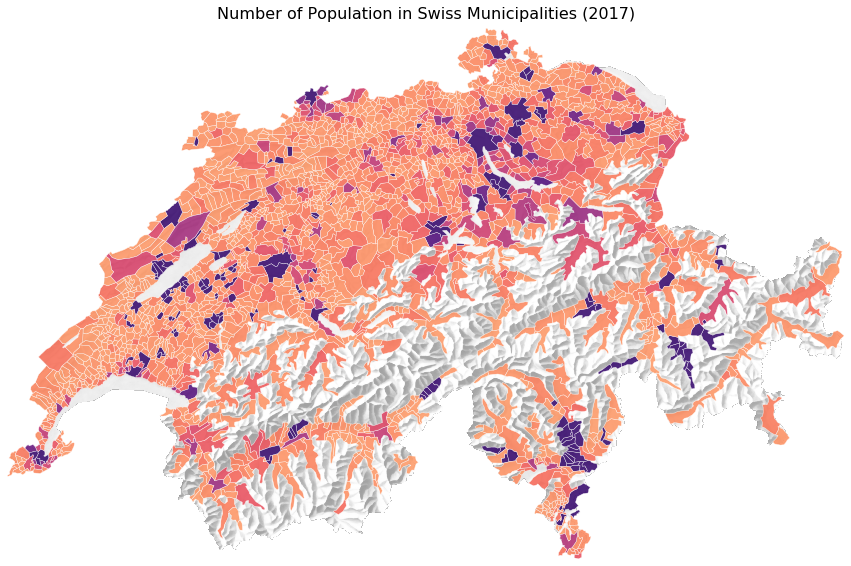

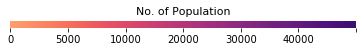

-------


In [7]:
population = df_swiss['Population'].values.tolist()
gemeinde_code = df_swiss['Gemeindecode'].values.tolist()
gemeinde_name =  df_swiss['Gemeindename'].values.tolist()

max_population = max(population)
min_population = min(population)
print (min_population, max_population)

up_population = 30000
low_population = 0

idx = population.index(max_population)

print ('population Num.: BFS ID', idx, '|', gemeinde_code[idx], '|', gemeinde_name[idx], '|', 'population: ', population[idx])
print ("-------")

# Nomarlization of Population   No NEED, foreigner in percentage %
population_norm = [(x-low_population)/(up_population-low_population) for x in population]
population_norm_cut = [max(min(x, 1), 0) for x in population_norm]

population_cut = [max(min(x, up_population), low_population) for x in population]

#Plot the population
thematic_plot(data_list=population_norm_cut, gemeindename=gemeinde_name, gemeindecode=gemeinde_code, variable_max=up_population, variable_min=low_population, variable_name='Population', cmapv='magma', titlev='Number of Population in Swiss Municipalities (2017)', cb_titlev='No. of Population', cb_ticks=['0', '5000', '10000', '20000','30000','40000'], mmDim = minMaxDim, width=width, height=height)
print ("-------")

#plt.figure()
#plt.plot(population_cut)
#plt.show()

## Average Age

[41.6182380199, 41.2000658654, 39.6035921607, 40.43422489, 40.1245262585]
34.4760914746 66.75
Most foreigner (%): BFS ID 1556 | 5102.0 | Corippo | Average Age:  66.75
-------
Plot MinMax, Width, Height:  [833175.0922758272, 485203.09316936514, 295864.00129457185, 75283.00188966928] 4971 3151
BG Img Shape:  (1169, 1846, 4)
BG Img Resized Shape:  (3151, 4971, 4)


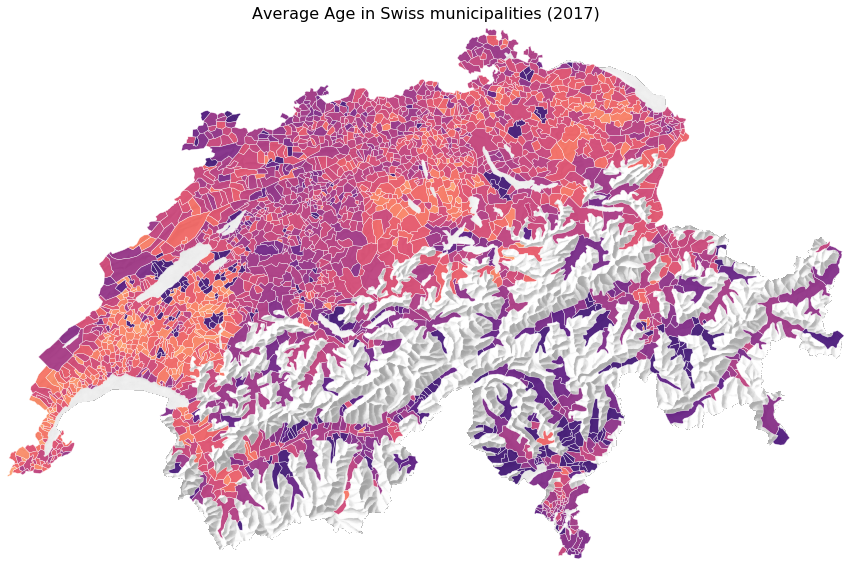

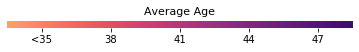

-------


In [8]:
age_10 = df_swiss['0-19 Jahre'].values
age_42 = df_swiss['20-64 Jahre'].values
age_75 = df_swiss['65 Jahre und mehr'].values

gemeinde_code = df_swiss['Gemeindecode'].values.tolist()
gemeinde_name =  df_swiss['Gemeindename'].values.tolist()

avr_age_arr = (age_10 * 10 + age_42*42 + age_75 * 75)/100
avr_age = avr_age_arr.tolist()
print (avr_age[0:5])

max_avr_age = max(avr_age)
min_avr_age = min(avr_age)
print (min_avr_age, max_avr_age)

up_avr_age = 47
low_avr_age = 37

idx = avr_age.index(max_avr_age)

print ('Most foreigner (%): BFS ID', idx, '|', gemeinde_code[idx], '|', gemeinde_name[idx], '|', 'Average Age: ', avr_age[idx])
print ("-------")

# Nomarlization of Population   No NEED, foreigner in percentage %
avr_age_norm = [(x-low_avr_age)/(up_avr_age-low_avr_age) for x in avr_age]
avr_age_norm_cut = [max(min(x, 1), 0) for x in avr_age_norm]
#foreigner_norm =[x/max_foreigner for x in foreigner]       #MUST BE BETWEEN 0 and 1

#print (avr_age)
avr_age_cut = [max(min(x, up_avr_age), low_avr_age) for x in avr_age]

#Plot the population
thematic_plot(data_list=avr_age_norm_cut, gemeindename=gemeinde_name, gemeindecode=gemeinde_code, variable_max=up_avr_age, variable_min=low_avr_age, variable_name='20-64 Jahre', cmapv='magma', titlev='Average Age in Swiss municipalities (2017)', cb_titlev='Average Age', cb_ticks=['<35', '38', '41', '44', '47','>50'], mmDim = minMaxDim, width=width, height=height)
print ("-------")

#plt.figure()
#plt.plot(avr_age_cut)
#plt.show()

## Foreign Residents

0.0 57.73809524
Most foreigner (%): BFS ID 1654 | 5407.0 | Leysin | Foreigner Percentage (in %):  57.73809524
-------
Plot MinMax, Width, Height:  [833175.0922758272, 485203.09316936514, 295864.00129457185, 75283.00188966928] 4971 3151
BG Img Shape:  (1169, 1846, 4)
BG Img Resized Shape:  (3151, 4971, 4)


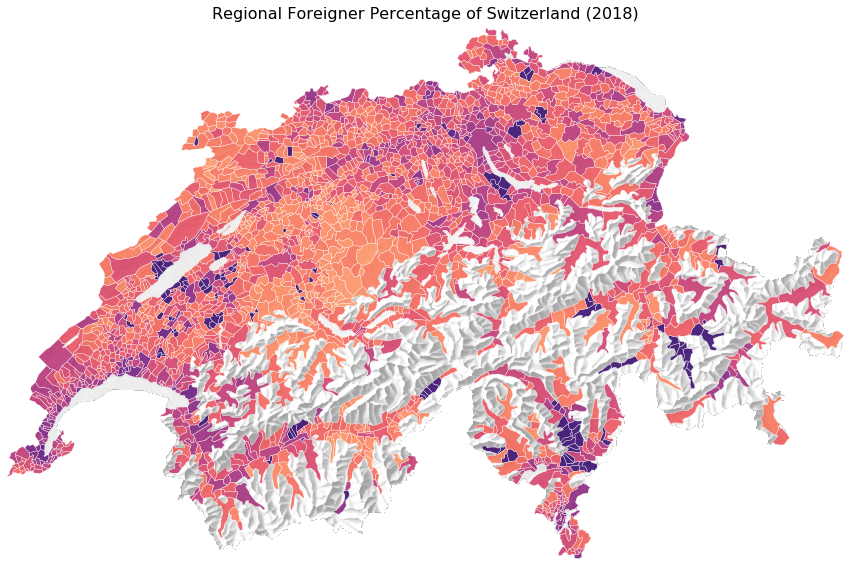

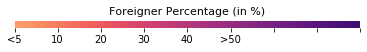

In [9]:
foreigner = df_swiss['Foreigner %'].values.tolist()
gemeinde_code = df_swiss['Gemeindecode'].values.tolist()
gemeinde_name =  df_swiss['Gemeindename'].values.tolist()

max_foreigner = max(foreigner)
min_foreigner = min(foreigner)
print (min_foreigner, max_foreigner)

up_foreigner = 40
low_foreigner = 0


idx = foreigner.index(max_foreigner)

print ('Most foreigner (%): BFS ID', idx, '|', gemeinde_code[idx], '|', gemeinde_name[idx], '|', 'Foreigner Percentage (in %): ', foreigner[idx])
print ("-------")

# Nomarlization of Population   No NEED, foreigner in percentage %
foreigner_norm = [(x-min_foreigner)/(max_foreigner-min_foreigner) for x in foreigner]                                 
#foreigner_norm =[x/max_foreigner for x in foreigner]       #MUST BE BETWEEN 0 and 1

#print (foreigner_norm)
#Plot the population
thematic_plot(data_list=foreigner_norm, gemeindename=gemeinde_name, gemeindecode=gemeinde_code, variable_max=up_foreigner, variable_min=low_foreigner, variable_name='Foreigner %', cmapv='magma', titlev='Regional Foreigner Percentage of Switzerland (2018)', cb_titlev='Foreigner Percentage (in %)', cb_ticks=['<5', '10', '20', '30', '40','>50'], mmDim = minMaxDim, width=width, height=height)


## Companies

0 44292
companys Num.: BFS ID 154 | 261.0 | Zürich | company:  44292
-------
Plot MinMax, Width, Height:  [833175.0922758272, 485203.09316936514, 295864.00129457185, 75283.00188966928] 4971 3151
BG Img Shape:  (1169, 1846, 4)
BG Img Resized Shape:  (3151, 4971, 4)


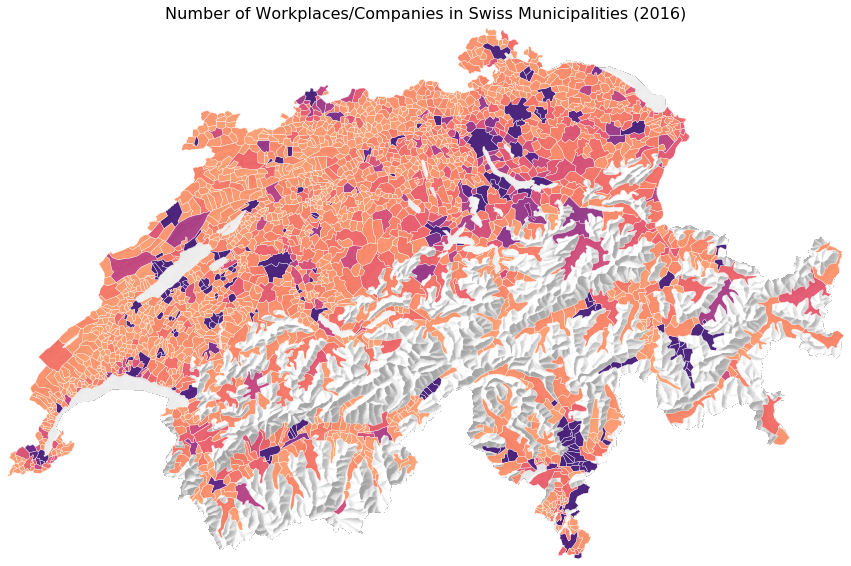

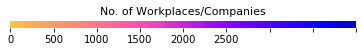

-------


In [11]:
company = df_swiss['Workplaces totally'].values.tolist()
gemeinde_code = df_swiss['Gemeindecode'].values.tolist()
gemeinde_name =  df_swiss['Gemeindename'].values.tolist()

max_company = max(company)
min_company = min(company)
print (min_company, max_company)

up_company = 2000
low_company = 0

idx = company.index(max_company)

print ('companys Num.: BFS ID', idx, '|', gemeinde_code[idx], '|', gemeinde_name[idx], '|', 'company: ', company[idx])
print ("-------")

# Nomarlization of Population   No NEED, foreigner in percentage %
company_norm = [(x-low_company)/(up_company-low_company) for x in company]
company_norm_cut = [max(min(x, 1), 0) for x in company_norm]

company_cut = [max(min(x, up_company), low_company) for x in company]

#Plot the population
thematic_plot(data_list=company_norm_cut, gemeindename=gemeinde_name, gemeindecode=gemeinde_code, variable_max=up_company, variable_min=low_company, variable_name='Workplaces totally', cmapv='gnuplot2', titlev='Number of Workplaces/Companies in Swiss Municipalities (2016)', cb_titlev='No. of Workplaces/Companies', cb_ticks=['0', '500', '1000', '1500','2000','2500'], mmDim = minMaxDim, width=width, height=height)
print ("-------")

#plt.figure()
#plt.plot(company_cut)
#plt.show()

## Marriage Rate

0.0 33.89830508
Highest marriage rate (%): BFS ID 883 | 2549.0 | Kammersrohr | marriage rate:  33.89830508
-------
Plot MinMax, Width, Height:  [833175.0922758272, 485203.09316936514, 295864.00129457185, 75283.00188966928] 4971 3151
BG Img Shape:  (1169, 1846, 4)
BG Img Resized Shape:  (3151, 4971, 4)


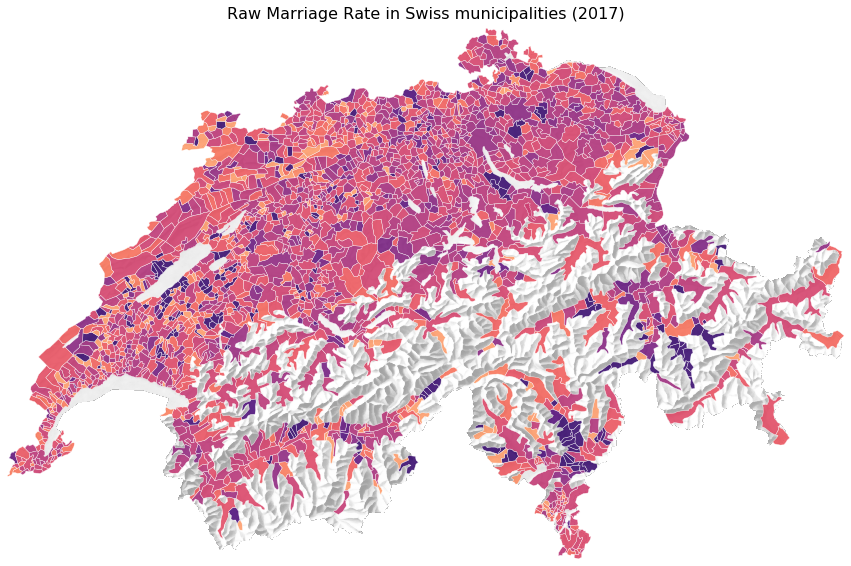

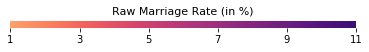

-------


In [14]:
marriage = df_swiss['Raw marriage rate'].values.tolist()

gemeinde_code = df_swiss['Gemeindecode'].values.tolist()
gemeinde_name =  df_swiss['Gemeindename'].values.tolist()

max_marriage = max(marriage)
min_marriage = min(marriage)
print (min_marriage, max_marriage)

up_marriage = 10
low_marriage = 0

idx = marriage.index(max(marriage))

print ('Highest marriage rate (%): BFS ID', idx, '|', gemeinde_code[idx], '|', gemeinde_name[idx], '|', 'marriage rate: ', marriage[idx])
print ("-------")

# Nomarlization of Population   No NEED, foreigner in percentage %
marriage_norm = [(x-low_marriage)/(up_marriage-low_marriage) for x in marriage]
marriage_norm_cut = [max(min(x, 1), 0) for x in marriage_norm]

marriage_cut = [max(min(x, up_marriage), low_marriage) for x in marriage]

#Plot the population
thematic_plot(data_list=marriage_norm_cut, gemeindename=gemeinde_name, gemeindecode=gemeinde_code, variable_max=up_marriage, variable_min=low_marriage, variable_name='Raw marriage rate', cmapv='magma', titlev='Raw Marriage Rate in Swiss municipalities (2017)', cb_titlev='Raw Marriage Rate (in %)', cb_ticks=['1', '3', '5', '7', '9','11'], mmDim = minMaxDim, width=width, height=height)
print ("-------")

## Divorce Rate

0.0 14.52784504
Highest marriage rate (%): BFS ID 242 | 423.0 | Willadingen | divorce rate:  14.52784504
-------
Plot MinMax, Width, Height:  [833175.0922758272, 485203.09316936514, 295864.00129457185, 75283.00188966928] 4971 3151
BG Img Shape:  (1169, 1846, 4)
BG Img Resized Shape:  (3151, 4971, 4)


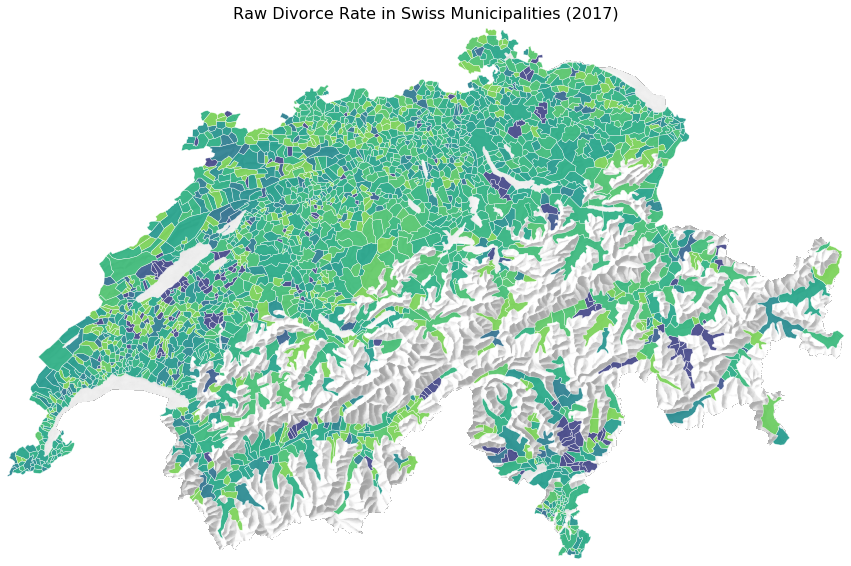

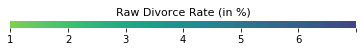

-------


In [16]:
divorce = df_swiss['Raw divorce rate'].values.tolist()

gemeinde_code = df_swiss['Gemeindecode'].values.tolist()
gemeinde_name =  df_swiss['Gemeindename'].values.tolist()

max_divorce = max(divorce)
min_divorce = min(divorce)
print (min_divorce, max_divorce)

up_divorce = 6
low_divorce = 0

idx = divorce.index(max(divorce))

print ('Highest marriage rate (%): BFS ID', idx, '|', gemeinde_code[idx], '|', gemeinde_name[idx], '|', 'divorce rate: ', divorce[idx])
print ("-------")

# Nomarlization of Population   No NEED, foreigner in percentage %
divorce_norm = [(x-low_divorce)/(up_divorce-low_divorce) for x in divorce]
divorce_norm_cut = [max(min(x, 1), 0) for x in divorce_norm]

divorce_cut = [max(min(x, up_divorce), low_divorce) for x in divorce]

#Plot the population
thematic_plot(data_list=divorce_norm_cut, gemeindename=gemeinde_name, gemeindecode=gemeinde_code, variable_max=up_divorce, variable_min=low_divorce, variable_name='Raw divorce rate', cmapv='viridis', titlev='Raw Divorce Rate in Swiss Municipalities (2017)', cb_titlev='Raw Divorce Rate (in %)', cb_ticks=['1', '2', '3', '4', '5','6'], mmDim = minMaxDim, width=width, height=height)
print ("-------")

## Thanks for your attention!